Name : Raman Randive
PRN: 123B1B240



In [2]:
# Install required libraries
!pip install pretty_midi mido librosa soundfile matplotlib numpy scipy torch
!apt-get install -y fluidsynth
!pip install pyfluidsynth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 78.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.11-py3-none-any.whl size=5595978 sha256=b16752152a2711634360b8df1ab42d77fe0b79b1e5f964caed31837bcbcbd779
  Stored in directory: /root/.cache/pip/wheels/f4/ad/93/a7042fe12668827574927ade9deec7f29aad2a1001b1501882
Successfully built pretty_midi
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm

In [3]:
import pretty_midi
import mido
import librosa
import librosa.display
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
# Cell 3: Load and inspect the MIDI file
midi_path = "/content/FILE.mid"
midi_data = pretty_midi.PrettyMIDI(midi_path)
print("Instruments found in MIDI:")
for instrument in midi_data.instruments:
    print(f"- {instrument.name if instrument.name else 'Unnamed Instrument'}")
print("\nTempo changes:", midi_data.get_tempo_changes())
print("Time signature changes:", midi_data.time_signature_changes)

Instruments found in MIDI:
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument
- Unnamed Instrument

Tempo changes: (array([0.]), array([123.99999173]))
Time signature changes: [TimeSignature(numerator=4, denominator=4, time=0.0)]


In [5]:
instrument = midi_data.instruments[0]  # first instrument
notes_data = []
for note in instrument.notes:
    notes_data.append({
        "pitch": note.pitch,
        "start_time": note.start,
        "end_time": note.end,
        "duration": note.end - note.start,
        "velocity": note.velocity
    })
notes_array = np.array([[n["pitch"], n["start_time"], n["end_time"], n["duration"], n["velocity"]]
                        for n in notes_data])
print(f"Extracted {len(notes_array)} notes")
print("First 5 notes:\n", notes_array[:5])

Extracted 949 notes
First 5 notes:
 [[8.40000000e+01 5.80746006e+00 5.94153265e+00 1.34072590e-01
  5.60000000e+01]
 [8.70000000e+01 5.80947619e+00 5.94354878e+00 1.34072590e-01
  5.60000000e+01]
 [8.40000000e+01 6.52621011e+00 6.61088754e+00 8.46774250e-02
  5.40000000e+01]
 [8.70000000e+01 6.53326656e+00 6.61794399e+00 8.46774250e-02
  5.60000000e+01]
 [8.40000000e+01 6.64213754e+00 6.72681496e+00 8.46774250e-02
  4.90000000e+01]]


Piano Roll Shape: (128, 26322)


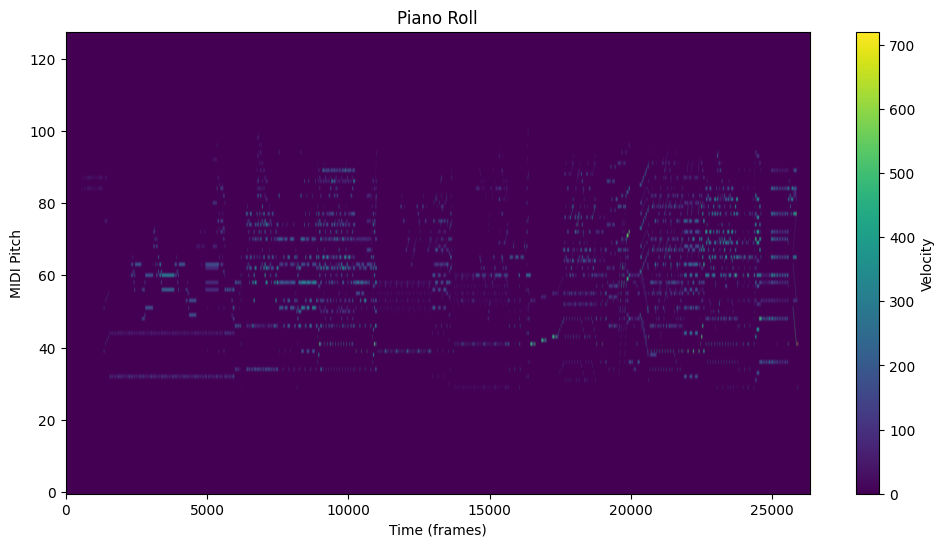

In [6]:
fs = 100  # frames per second
piano_roll = midi_data.get_piano_roll(fs=fs)
print("Piano Roll Shape:", piano_roll.shape)
plt.figure(figsize=(12,6))
plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='viridis')
plt.title("Piano Roll")
plt.xlabel("Time (frames)")
plt.ylabel("MIDI Pitch")
plt.colorbar(label="Velocity")
plt.show()

In [7]:
audio_data = midi_data.synthesize()
sf.write("original_audio.wav", audio_data, 44100)
print("Original MIDI converted to audio: original_audio.wav")

Original MIDI converted to audio: original_audio.wav


In [8]:
piano_roll_norm = piano_roll.T / 127.0  # shape: (time_steps, 128)
data_tensor = torch.tensor(piano_roll_norm, dtype=torch.float32)
print("Data tensor shape for GAN:", data_tensor.shape)

Data tensor shape for GAN: torch.Size([26322, 128])


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 128),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(128, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

G = Generator().to(device)
D = Discriminator().to(device)

In [13]:
lr = 0.0002
num_epochs = 500
batch_size = 16
criterion = nn.BCELoss()
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr)
optimizer_G = torch.optim.Adam(G.parameters(), lr=lr)
real_label = 1.0
fake_label = 0.0

In [ ]:
data_tensor = data_tensor.to(device)
for epoch in range(num_epochs):
    perm = torch.randperm(data_tensor.size(0))
    data_shuffled = data_tensor[perm]
    for i in range(0, data_shuffled.size(0), batch_size):
        real_batch = data_shuffled[i:i+batch_size]
        b_size = real_batch.size(0)

        # Train Discriminator
        D.zero_grad()
        labels_real = torch.full((b_size, 1), real_label, device=device)
        output_real = D(real_batch)
        loss_D_real = criterion(output_real, labels_real)

        noise = torch.randn(b_size, noise_dim, device=device)
        fake = G(noise)
        labels_fake = torch.full((b_size, 1), fake_label, device=device)
        output_fake = D(fake.detach())
        loss_D_fake = criterion(output_fake, labels_fake)

        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        G.zero_grad()
        labels_gen = torch.full((b_size, 1), real_label, device=device)
        output_gen = D(fake)
        loss_G = criterion(output_gen, labels_gen)
        loss_G.backward()
        optimizer_G.step()

    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

In [ ]:
G.eval()
with torch.no_grad():
    z = torch.randn(1, noise_dim, device=device)
    generated_roll = G(z).cpu().numpy().reshape(128, -1)
generated_roll = (generated_roll * 127).astype(int)
generated_roll = np.clip(generated_roll, 0, 127)
print("Generated guitar shape:", generated_roll.shape)

In [ ]:
generated_midi = pretty_midi.PrettyMIDI()
instrument = pretty_midi.Instrument(program=0)
fs = 100
time_step = 1/fs
for pitch in range(generated_roll.shape[0]):
    velocities = generated_roll[pitch]
    start = None
    for t, vel in enumerate(velocities):
        if vel > 0 and start is None:
            start = t * time_step
        elif (vel == 0 or t == len(velocities)-1) and start is not None:
            end = t * time_step
            note = pretty_midi.Note(
                velocity=int(np.max(velocities[int(start*time_step*fs):t+1])),
                pitch=pitch,
                start=start,
                end=end
            )
            instrument.notes.append(note)
            start = None
generated_midi.instruments.append(instrument)
generated_midi.write("generated_music.mid")
print("Generated MIDI saved as 'generated_music.mid'")

In [ ]:
generated_audio = generated_midi.synthesize()
sf.write("generated_music.wav", generated_audio, 44100)
print("Generated MIDI converted to audio: 'generated_music.wav'")

In [ ]:
# Load the audio file created earlier
audio_path = "original_audio.wav"
y, sr = librosa.load(audio_path)

# Generate the mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# Convert to decibels (dB) for better visualization
S_DB = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot the mel spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB', label="Intensity (dB)")
plt.title("Mel Spectrogram")
plt.show()